In [1]:
import numpy as np
from pathlib import Path
from mintpy.utils import readfile
from mintpy.utils import utils as ud
from matplotlib import pyplot as plt

In [31]:
import os 
os.chdir('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM')

In [4]:
%load_ext autoreload
%autoreload 2

In [4]:
##########################################################
from dask_cluster import local_cluster, split2boxes
from tqdm import tqdm

In [5]:
def snwe_to_extent(snwe):
    return [snwe[2], snwe[3], snwe[0], snwe[1]]

def disp_unit_vector(incidenceAngle:np.float64, azimuthAngle:np.float64):
    '''
    azimuthAngle  - 0 at east, as it is in ISCE2 convention 

    '''
    dn = np.multiply(np.sin(np.deg2rad(incidenceAngle)), np.cos(np.deg2rad(azimuthAngle)))
    de = np.multiply(np.sin(np.deg2rad(incidenceAngle)), -np.sin(np.deg2rad(azimuthAngle)))
    dv = np.cos(np.deg2rad(incidenceAngle))
    
    return dn, de, dv

def _get_window_snwe(attr:dict, win_x:list, win_y:list):
    # From the upper right corner
    coord = ud.coordinate(attr)
    box = [win_x[0], win_y[0], win_x[1], win_y[1]]
    w, n, e, s = coord.bbox_radar2geo(box)
    return np.r_[s, n, w, e]

def _get_win_lalo_grid(attr:dict, 
                       win_x:list, win_y:list) -> [np.ndarray, np.ndarray]:
    snwe = _get_window_snwe(attr, win_x, win_y)
    lons = np.linspace(snwe[2], snwe[3],win_x[1]- win_x[0])#np.float64(attr['X_STEP']))[:-1]
    lats = np.linspace(snwe[1], snwe[0],win_y[1]- win_y[0])#, win_x1[1]-win_x1[0])np.float64(attr['Y_STEP']))[:-1]
    return np.meshgrid(lons, lats)

def _get_patch_nan_flag(input_array):
    flag = input_array[~np.isnan(input_array)].size
    flag = True if flag ==0 else False
    return flag

def _get_snwe_spacing(attr:dict):
    snwe = ud.four_corners(attr)
    latlon_step = np.float64([attr['Y_STEP'], attr['X_STEP']])
    data_shape = np.int16([attr['LENGTH'], attr['WIDTH']])
    return snwe, latlon_step, data_shape

## Load Calibrated InSAR tracks

In [6]:
# Get all calibrated tracks
calibrated_insar = [Path('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/CAL/MIDAS/cal_A034_2000_2024_fft.h5')]
calibrated_insar

[PosixPath('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/CAL/MIDAS/cal_A034_2000_2024_fft.h5')]

In [7]:
# Split calibrated product into two group: derived with fft and lowess
cal_insar_fft = []
cal_insar = []

for i in calibrated_insar:
    if len(str(i.name).split('_')) > 2:
        cal_insar_fft.append(i)
    else:
        cal_insar.append(i)

In [8]:
cal_insar

[]

In [9]:
geometry = [Path('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/opera_disp/MINTPY/geometry.h5')]
geometry

[PosixPath('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/opera_disp/MINTPY/geometry.h5')]

In [10]:
# Get the track geometry information
snwe_list = []
latlon_list = []
dims_list = []

for insar_track in cal_insar_fft:
    track_geom = _get_snwe_spacing(readfile.read_attribute(insar_track))
    snwe_list.append(track_geom[0])
    latlon_list.append(track_geom[1])
    dims_list.append(track_geom[2])

In [11]:
# Combine all tracks to same grid
n = len(snwe_list)
snwe_all = np.vstack(snwe_list)

# Assume all tracks have the same spacing
latlon_step = np.unique(np.vstack(latlon_list))
print(latlon_step)

# Get SNWE extent
snwe = np.array([np.min(snwe_all[:,0]), np.max(snwe_all[:,1]),
                 np.min(snwe_all[:,2]), np.max(snwe_all[:,3])]).T
print(snwe)
# Get new length/ width
length = abs(int(np.around((snwe[1] - snwe[0]) / latlon_step[0])))
width = abs(int(np.around((snwe[2] - snwe[3]) / latlon_step[1])))

# update S and E
snwe = np.array([snwe[1] + (length) * latlon_step[0], snwe[1],
                 snwe[2], snwe[2] + (width) * latlon_step[1]])

# Get the grid
d_lats, d_lons = np.mgrid[snwe[1]:snwe[0] + latlon_step[0]:(length)*1j,
                          snwe[2]:snwe[3] + latlon_step[1]:(width)*1j]

[-30.  30.]
[3153930. 3385920.   71970.  355890.]


In [12]:
# Comb attr dict
comb_dict = {'Y_FIRST':snwe[1], 'X_FIRST':snwe[2],
             'Y_STEP':latlon_step[0], 'X_STEP':latlon_step[1],
             'LENGTH':length, 'WIDTH':width}

# Initialize MIntpy class coordinates
coord = ud.coordinate(comb_dict)

In [13]:
# Create common grid datasets
comb_data = np.empty((n, length, width), dtype=np.float64) * np.nan
comb_stds = np.empty((n, length, width), dtype=np.float64) * np.nan
comb_inc = np.empty((n, length, width), dtype=np.float64) * np.nan
comb_azi = np.empty((n, length, width), dtype=np.float64) * np.nan

In [14]:
for ix, track_snwe in enumerate(snwe_list):
    box = [track_snwe[2], track_snwe[0], track_snwe[3], track_snwe[1]]
    rbox = coord.bbox_geo2radar(box)
    rbox = np.s_[ix, rbox[1]:rbox[3], rbox[0]:rbox[2]]
    print(rbox)
    comb_data[rbox] = np.ma.masked_equal(readfile.read(cal_insar_fft[ix],
                                                       datasetName='cal_velocity')[0], 0).filled(np.nan)
    comb_stds[rbox] = np.ma.masked_equal(readfile.read(cal_insar_fft[ix],
                                                       datasetName='cal_velocityStd')[0], 0)
    comb_inc[rbox] = np.ma.masked_equal(readfile.read(geometry[ix],
                                                      datasetName='incidenceAngle')[0], 0)
    comb_azi[rbox] = np.ma.masked_equal(readfile.read(geometry[ix],
                                                      datasetName='azimuthAngle')[0], 0)  

(0, slice(0, 7733, None), slice(0, 9464, None))


In [15]:
comb_data2 = np.zeros((n, length, width), dtype=np.float64)
for ix, track_snwe in enumerate(snwe_list):
    box = [track_snwe[2], track_snwe[0], track_snwe[3], track_snwe[1]]
    rbox = coord.bbox_geo2radar(box)
    rbox = np.s_[ix, rbox[1]:rbox[3], rbox[0]:rbox[2]]
    print(rbox)
    comb_data2[rbox] = np.ma.masked_equal(readfile.read(cal_insar_fft[ix],
                                                       datasetName='cal_velocity')[0], 0)

(0, slice(0, 7733, None), slice(0, 9464, None))


In [16]:
count_data = np.count_nonzero(comb_data2, axis=0)

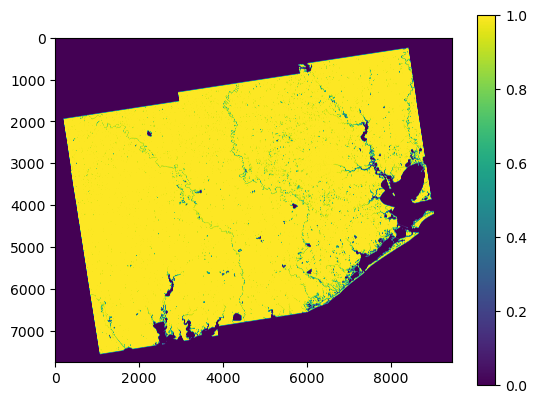

In [17]:
plt.imshow(count_data)
plt.colorbar()

In [16]:
comb_dict['UNIT'] = '#'
comb_dict['SNWE'] = snwe
comb_dict['FILE_TYPE'] = 'mask'
ds_dict = dict(count=[np.float32, (count_data.shape[0], count_data.shape[1]), None])

ds_unit_dict = dict(count='#')
from mintpy.utils import writefile
length, width = count_data.shape
writefile.layout_hdf5('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/count.h5',
                      metadata=comb_dict,
                      ds_name_dict=ds_dict,
                      ds_unit_dict=ds_unit_dict)

writefile.write_hdf5_block('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/count.h5',
                            data=count_data,
                            datasetName='count')

--------------------------------------------------
create HDF5 file: /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/count.h5 with w mode
create dataset  : count of <class 'numpy.float32'>   in size of (7733, 9464)         with compression = None
add /count attribute: UNIT = #
close  HDF5 file: /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/count.h5
--------------------------------------------------
open  HDF5 file /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/count.h5 in a mode
writing dataset /count                     block: [0, 7733, 0, 9464]
close HDF5 file /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/count.h5.


'/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/count.h5'

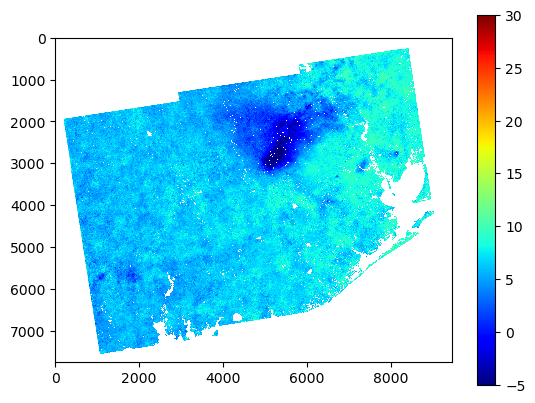

In [17]:
kwargs = dict(clim=[-5, 30], interpolation='nearest', cmap='jet')
fig, ax = plt.subplots(1)
im = ax.imshow(np.ma.masked_equal(comb_data[0], 0), **kwargs)
fig.colorbar(im)

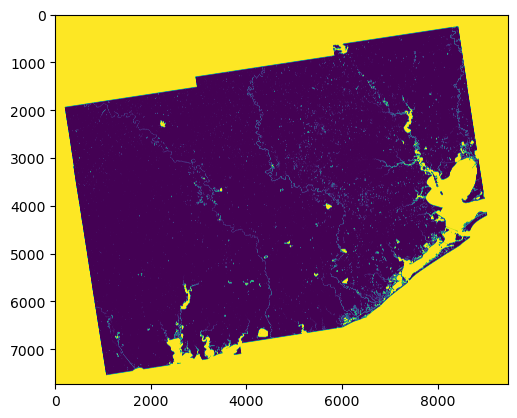

In [18]:
plt.imshow(np.ma.masked_invalid(comb_data[0], 0).mask)

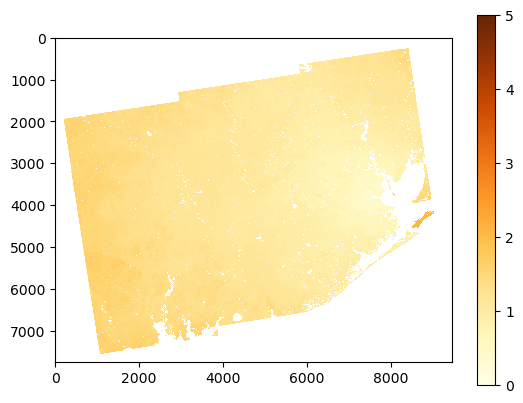

In [19]:
kwargs = dict(clim=[0, 5], interpolation='nearest', cmap='YlOrBr')
fig, ax = plt.subplots(1)
im = ax.imshow(np.ma.masked_array(comb_stds[0], mask=np.ma.masked_invalid(comb_data[0]).mask), **kwargs)
fig.colorbar(im)

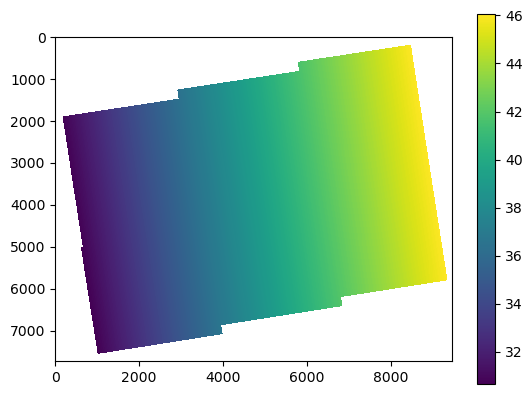

In [20]:
kwargs = dict(interpolation='nearest', cmap='viridis')
fig, ax = plt.subplots(1)
im = ax.imshow(np.ma.masked_equal(comb_inc[0], 0), **kwargs)
fig.colorbar(im)

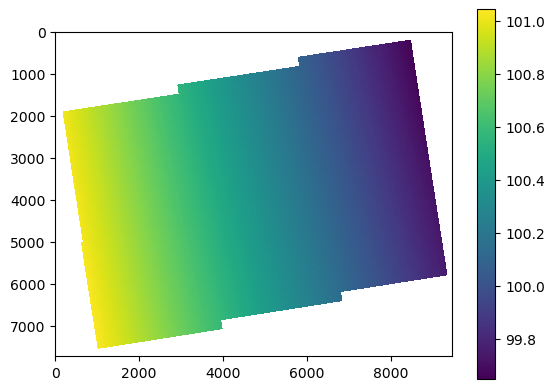

In [21]:
kwargs = dict(interpolation='nearest', cmap='viridis')
fig, ax = plt.subplots(1)
im = ax.imshow(np.ma.masked_equal(comb_azi[0], 0), **kwargs)
fig.colorbar(im)

## Prepare GNSS model

In [20]:
from scipy import interpolate
#from ../src.gps import UNR
import geopandas as gpd 

In [ ]:
# gnss
# Setup
gnss_pickle = '/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/gnss/GNSS/unr_gnss_midas_2014_2024.pickle.pkl'

# Initialize UNR class
gnss = UNR()
gnss = gnss.load(gnss_pickle)

gnss_points = gpd.points_from_xy(gnss.gnss_df.lon,
                                 gnss.gnss_df.lat)

# Plot downloaded UNR sites
gnss_df = gpd.GeoDataFrame(gnss.gnss_df,
                           geometry = gnss_points,
                           crs='EPSG:4326')

FileNotFoundError: [Errno 2] No such file or directory: '/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/gnss/GNSS/unr_gnss_midas_2014_2024.pickle.pkl.pkl'

In [26]:
horz_std = np.sqrt(gnss_df.se**2 + gnss_df.sn**2)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(9,6), sharey=True)
im = plt.scatter(gnss_df.lon, gnss_df.lat, s=20, c=horz_std, cmap='YlOrBr', zorder=1)
fig.colorbar(im, ax=ax, shrink=0.6,
                 location='right', pad=0.1, 
                 extend='both', label='[mm/yr]')
ax.set_title('3D Velocity std.')

NameError: name 'gnss_df' is not defined

In [ ]:
th = np.round(np.mean(horz_std) + np.std(horz_std), 2)
gnss_df2 = gnss_df.drop(gnss_df[horz_std > (th)].index, axis=0)
print(f'Number of sites: {gnss_df.shape[0]}')
print(f'Number of kept sites: {gnss_df2.shape[0]}')

Number of sites: 1020
Number of kept sites: 1000


Text(0.5, 1.0, '3D Velocity std.')

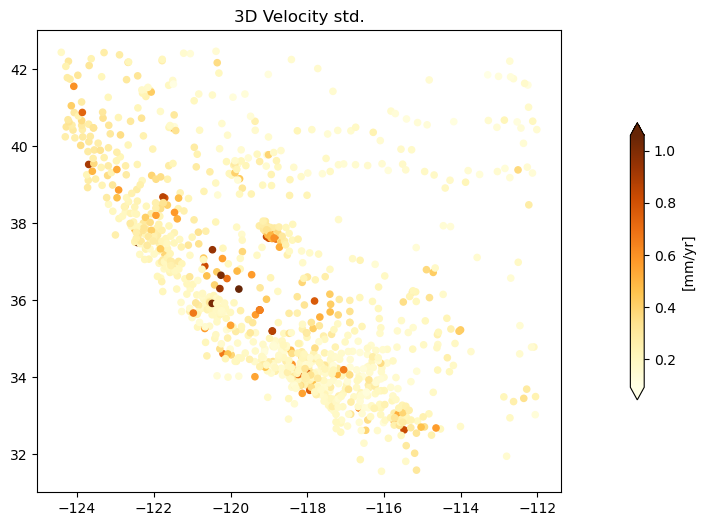

In [ ]:
# Plot
horz_std2 = np.sqrt(gnss_df2.se**2 + gnss_df2.sn**2)
fig, ax = plt.subplots(1, 1, figsize=(9,6), sharey=True)
im = plt.scatter(gnss_df2.lon, gnss_df2.lat, s=20, c=horz_std2, cmap='YlOrBr', zorder=1)
fig.colorbar(im, ax=ax, shrink=0.6,
                 location='right', pad=0.1, 
                 extend='both', label='[mm/yr]')
ax.set_title('3D Velocity std.')

In [22]:
th = np.round(np.mean(horz_std2) + np.std(horz_std2), 2)
gnss_df3 = gnss_df2.drop(gnss_df2[horz_std2 > (th)].index, axis=0)
print(f'Number of sites: {gnss_df2.shape[0]}')
print(f'Number of kept sites: {gnss_df3.shape[0]}')

Number of sites: 1000
Number of kept sites: 896


Text(0.5, 1.0, '3D Velocity std.')

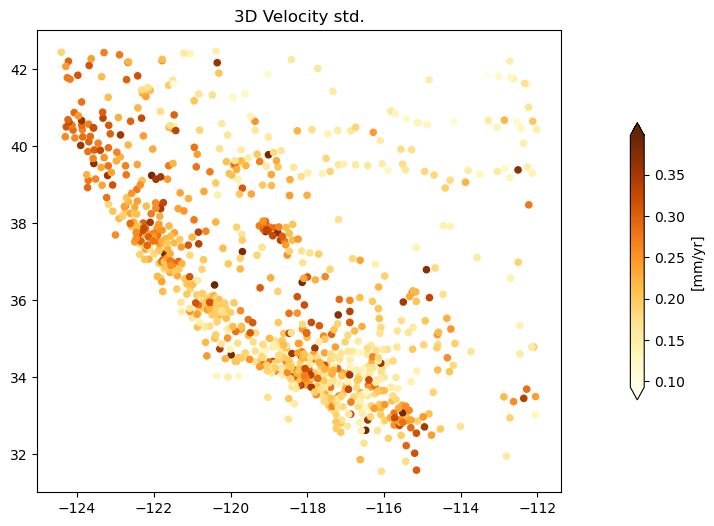

In [23]:
horz_std3 = np.sqrt(gnss_df3.se**2 + gnss_df3.sn**2)
fig, ax = plt.subplots(1, 1, figsize=(9,6), sharey=True)
im = plt.scatter(gnss_df3.lon, gnss_df3.lat, s=20, c=horz_std3, cmap='YlOrBr', zorder=1)
fig.colorbar(im, ax=ax, shrink=0.6,
                 location='right', pad=0.1, 
                 extend='both', label='[mm/yr]')
ax.set_title('3D Velocity std.')

In [24]:
gps_interpolated2 = dict(ew=None, ns=None, se=None, sn=None)
for gps_data, key in zip([gnss_df3.e, gnss_df3.n, gnss_df3.se, gnss_df3.sn],
                 ['ew', 'ns', 'se', 'sn']):
    
    gps_interpolated2[key] = interpolate.griddata((gnss_df3.lat, gnss_df3.lon),
                                                  gps_data,
                                                  (d_lats, d_lons),
                                                  method='linear', 
                                                  fill_value=np.nan)

## use prepared model

In [21]:
# Setup
#gnss_model = gpd.read_file('/u/trappist-r0/govorcin/06_PAPERS/VLM_CA/02_GNSS_MODEL/gnss_grid_5km')
#gnss_model = gpd.read_file('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/gnss//gnss_grid_5km')
gnss_model = gpd.read_file('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/GNSS/2000_2024/gnss_grid_30_midas_2000_2024')

In [22]:
from pyproj import Transformer
# Init projection converter 
transformer = Transformer.from_crs( "EPSG:4326", f"EPSG:{readfile.read_attribute(cal_insar_fft[0])['EPSG']}", always_xy=True)

points_latlon = [(d.lon, d.lat) for _, d in gnss_model.iterrows()]
points_utm = list(transformer.itransform(points_latlon))

gnss_model['x'] = np.vstack(points_utm)[:,0]
gnss_model['y'] = np.vstack(points_utm)[:,1]

In [23]:

gps_interpolated = dict(ew=None, ns=None, se=None, sn=None)
for gps_data, key in zip([gnss_model.ew, gnss_model.ns, gnss_model.sew, gnss_model.sns],
                 ['ew', 'ns', 'se', 'sn']):
    
    gps_interpolated[key] = interpolate.griddata((gnss_model.y, gnss_model.x),
                                                  gps_data,
                                                  (d_lats, d_lons),
                                                  method='linear', 
                                                  fill_value=np.nan)

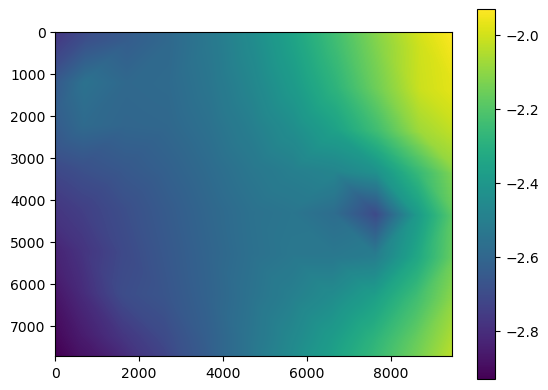

In [24]:
plt.imshow(gps_interpolated['ns'])
plt.colorbar()

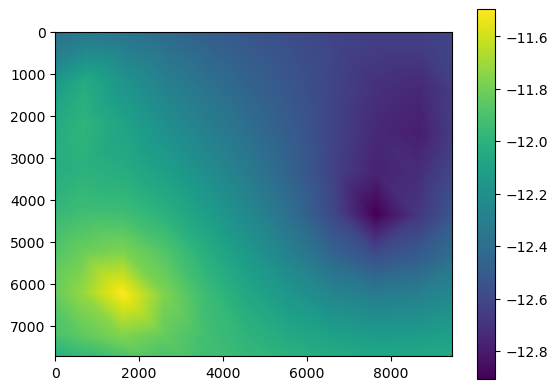

In [25]:
plt.imshow(gps_interpolated['ew'])
plt.colorbar()

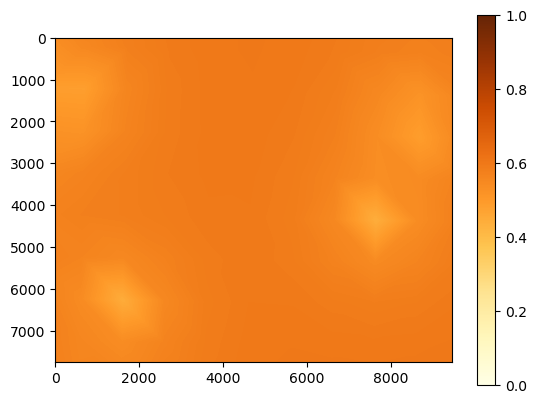

In [26]:
plt.imshow(gps_interpolated['sn'], clim=[0,1], cmap='YlOrBr')
plt.colorbar()

## LOS Decomposition

In [27]:
size_in_gb = comb_data.nbytes * 1e-9
#multiply with the number of combined arrays
size_in_gb *=4
n_patches = np.int32(np.round(size_in_gb / 1))

In [28]:
cluster = local_cluster(100)
cluster.open()
cluster.client.upload_file('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/los2disp3d.py')

initiate Dask cluster
scale Dask cluster to 100 workers
initiate Dask client
http://127.0.0.1:8787/status


{'tcp://127.0.0.1:32843': {'status': 'OK'},
 'tcp://127.0.0.1:32917': {'status': 'OK'},
 'tcp://127.0.0.1:33173': {'status': 'OK'},
 'tcp://127.0.0.1:33211': {'status': 'OK'},
 'tcp://127.0.0.1:33271': {'status': 'OK'},
 'tcp://127.0.0.1:33485': {'status': 'OK'},
 'tcp://127.0.0.1:34193': {'status': 'OK'},
 'tcp://127.0.0.1:34218': {'status': 'OK'},
 'tcp://127.0.0.1:34266': {'status': 'OK'},
 'tcp://127.0.0.1:34287': {'status': 'OK'},
 'tcp://127.0.0.1:34354': {'status': 'OK'},
 'tcp://127.0.0.1:34380': {'status': 'OK'},
 'tcp://127.0.0.1:34481': {'status': 'OK'},
 'tcp://127.0.0.1:34732': {'status': 'OK'},
 'tcp://127.0.0.1:34967': {'status': 'OK'},
 'tcp://127.0.0.1:35121': {'status': 'OK'},
 'tcp://127.0.0.1:35127': {'status': 'OK'},
 'tcp://127.0.0.1:35231': {'status': 'OK'},
 'tcp://127.0.0.1:35651': {'status': 'OK'},
 'tcp://127.0.0.1:35711': {'status': 'OK'},
 'tcp://127.0.0.1:35766': {'status': 'OK'},
 'tcp://127.0.0.1:35974': {'status': 'OK'},
 'tcp://127.0.0.1:35989': {'stat

In [32]:
from los2disp3d import loop_invert_asc_dsc2 as loop_inv
dim, length, width = comb_data.shape

patches = split2boxes(length, width, n_patches, 'y')
# Create empty result array
comb_disp = np.empty((3, length, width), dtype=np.float64) * np.nan
comb_stdx = np.empty((3, length, width), dtype=np.float64) * np.nan
comb_mse = np.empty((length, width), dtype=np.float64) * np.nan
comb_ngeom = np.empty((length, width), dtype=np.float64) * np.nan

ns = np.empty((2, length, width), dtype=np.float64) * np.nan
ns[0] = gps_interpolated['ns']
ns[1] = gps_interpolated['sn']

ew = np.empty((2, length, width), dtype=np.float64) * np.nan
ew[0] = gps_interpolated['ew']
ew[1] = gps_interpolated['se']


for i in tqdm(patches, total=len(patches)):
    #print('Running patch: ', i)
    
    ### Extract the slice
    nslice = tuple(np.append(np.s_[:], i))
    data = comb_data[nslice]
    dim, length, width = data.shape
    std = comb_stds[nslice]
    inc = comb_inc[nslice]
    azi = comb_azi[nslice]

    data = np.ma.masked_equal(data, 0).filled(np.nan)
    rm_index = [_get_patch_nan_flag(d) for d in data]

    # Squeeze arrays, e.g. remove layers with all nans
    data = np.delete(data, rm_index, axis=0)
    std = np.delete(std, rm_index, axis=0) 
    inc = np.delete(inc, rm_index, axis=0)
    azi = np.delete(azi, rm_index, axis=0)
    
    ns_s = ns[nslice]
    ew_s = ew[nslice]
    
    func_data = {"data": data,
                 "std": std,
                 "inc": inc,
                 "azi": azi,
                 "ns": ns_s,
                 "ew": ew_s}
    # init outputs
    disp = np.empty((3, length, width), dtype=np.float64) * np.nan
    stdx = np.empty((3, length, width), dtype=np.float64) * np.nan
    mse = np.empty((length, width), dtype=np.float64) * np.nan
    ngeom = np.empty((length, width), dtype=np.float64) * np.nan
    
    #run processing in parallel with dask
    disp, stdx, mse, ngeom = cluster.run(loop_inv, 
                                  func_data=func_data, 
                                  results=[disp, stdx, mse, ngeom],
                                  verbose=False)
    
    comb_disp[nslice] = disp
    comb_stdx[nslice] = stdx
    comb_mse[nslice[1:]] = mse
    comb_ngeom[nslice[1:]] = ngeom 
cluster.close()

  0%|          | 0/2 [00:00<?, ?it/s]/u/trappist-r0/govorcin/src/tools/conda/envs/insar2/lib/python3.11/site-packages/distributed/worker.py:3039: UserWarning: Large object of size 22.42 MiB detected in task graph: 
  {'data': array([[[nan, nan, nan, ..., nan, nan, na ... (0, 95, None))}
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
100%|██████████| 2/2 [06:29<00:00, 194.80s/it]
2024-12-23 10:26:49,570 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/u/trappist-r0/govorcin/src/tools/conda/envs/insar2/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^

close dask cluster
close dask client


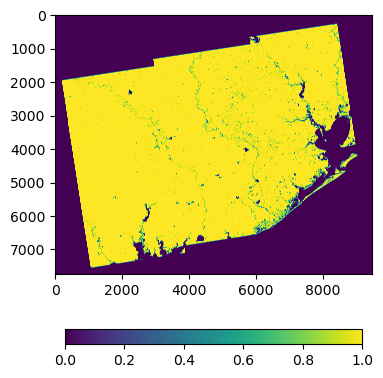

In [33]:
plt.imshow(comb_ngeom)
plt.colorbar(location='bottom', shrink=0.6)

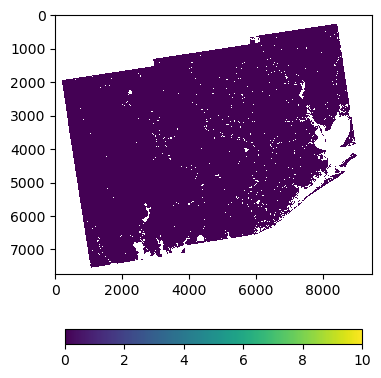

In [33]:
plt.imshow(comb_mse, clim=[0,10], interpolation='nearest')
plt.colorbar(location='bottom', shrink=0.6)

Text(0.5, 1.0, 'East-West')

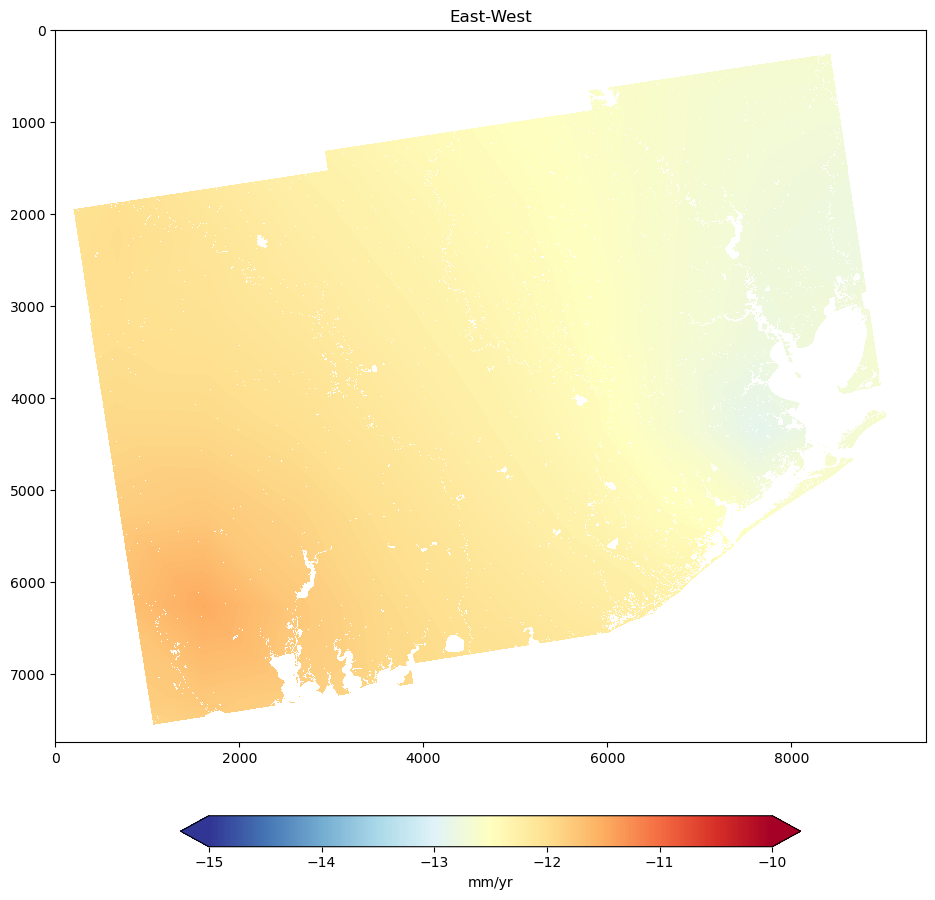

In [34]:
fig, ax = plt.subplots(1,1, figsize=[16, 12])
im = ax.imshow(np.ma.masked_array(comb_disp[1], mask=np.ma.masked_less(comb_ngeom,1).mask),
               cmap='RdYlBu_r', clim=[-15,-10], interpolation='nearest')
fig.colorbar(im ,ax=ax, location='bottom', shrink=0.5, label='mm/yr', extend='both',pad=0.08)
ax.set_title('East-West')

Text(0.5, 1.0, 'North-South')

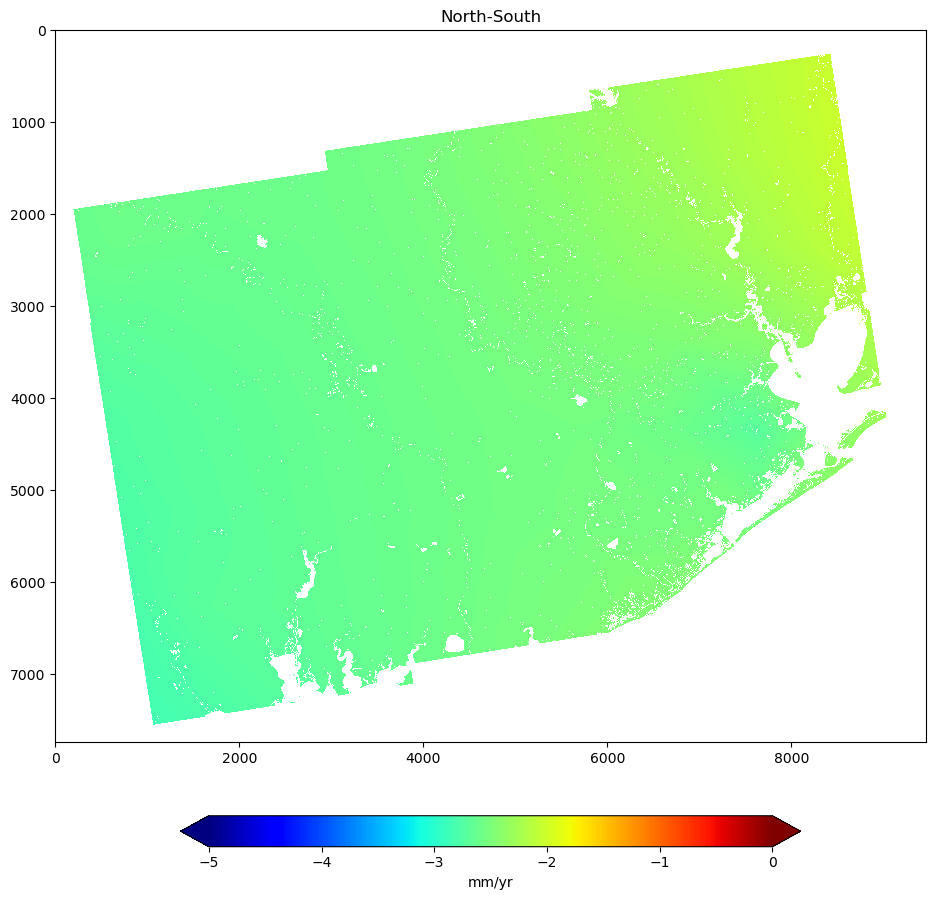

In [35]:
fig, ax = plt.subplots(1,1, figsize=[16,12])
im=ax.imshow(np.ma.masked_array(comb_disp[0],
            mask=np.ma.masked_less(comb_ngeom,1).mask), 
          clim=[-5, 0], 
          cmap='jet', 
          interpolation='nearest')
fig.colorbar(im ,ax=ax, location='bottom', shrink=0.5, label='mm/yr', extend='both',pad=0.08)
ax.set_title('North-South')

Text(0.5, 1.0, 'VLM')

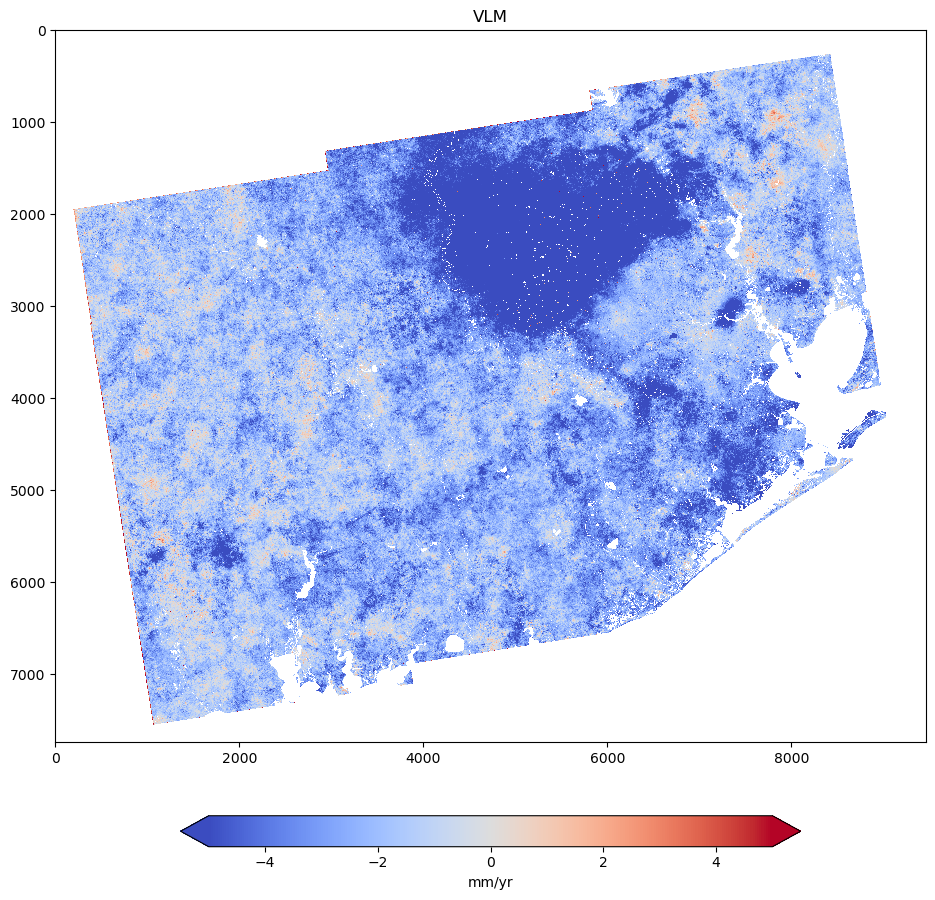

In [36]:
fig, ax = plt.subplots(1,1, figsize=[16,12])
im=ax.imshow(np.ma.masked_array(comb_disp[2],
            mask=np.ma.masked_less(comb_ngeom,1).mask), 
          clim=[-5, 5], 
          cmap='coolwarm', 
          interpolation='nearest')
fig.colorbar(im ,ax=ax, location='bottom', shrink=0.5, label='mm/yr', extend='both',pad=0.08)
ax.set_title('VLM')

Text(0.5, 1.0, 'VLM')

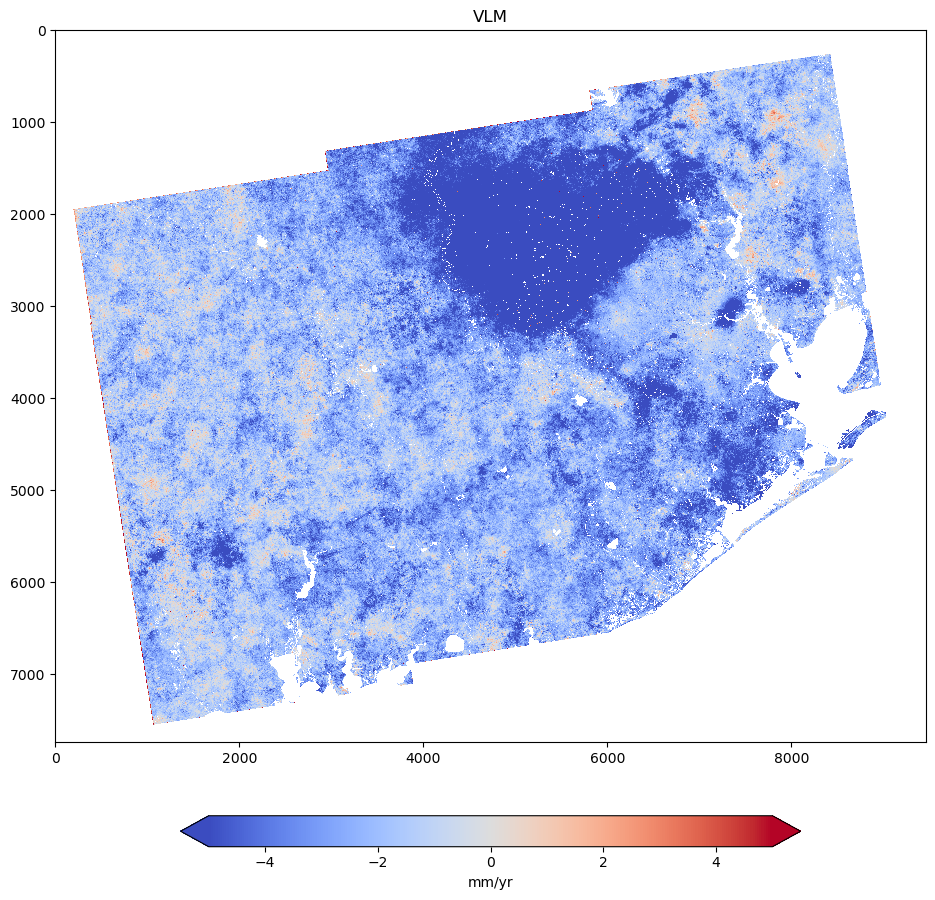

In [37]:
fig, ax = plt.subplots(1,1, figsize=[16,12])
im=ax.imshow(np.ma.masked_array(comb_disp[2],
            mask=np.ma.masked_less(comb_ngeom,1).mask), 
          clim=[-5, 5], 
          cmap='coolwarm', 
          interpolation='nearest')
fig.colorbar(im ,ax=ax, location='bottom', shrink=0.5, label='mm/yr', extend='both',pad=0.08)
ax.set_title('VLM')

In [38]:
extent = [snwe[2], snwe[3], snwe[0], snwe[1]]

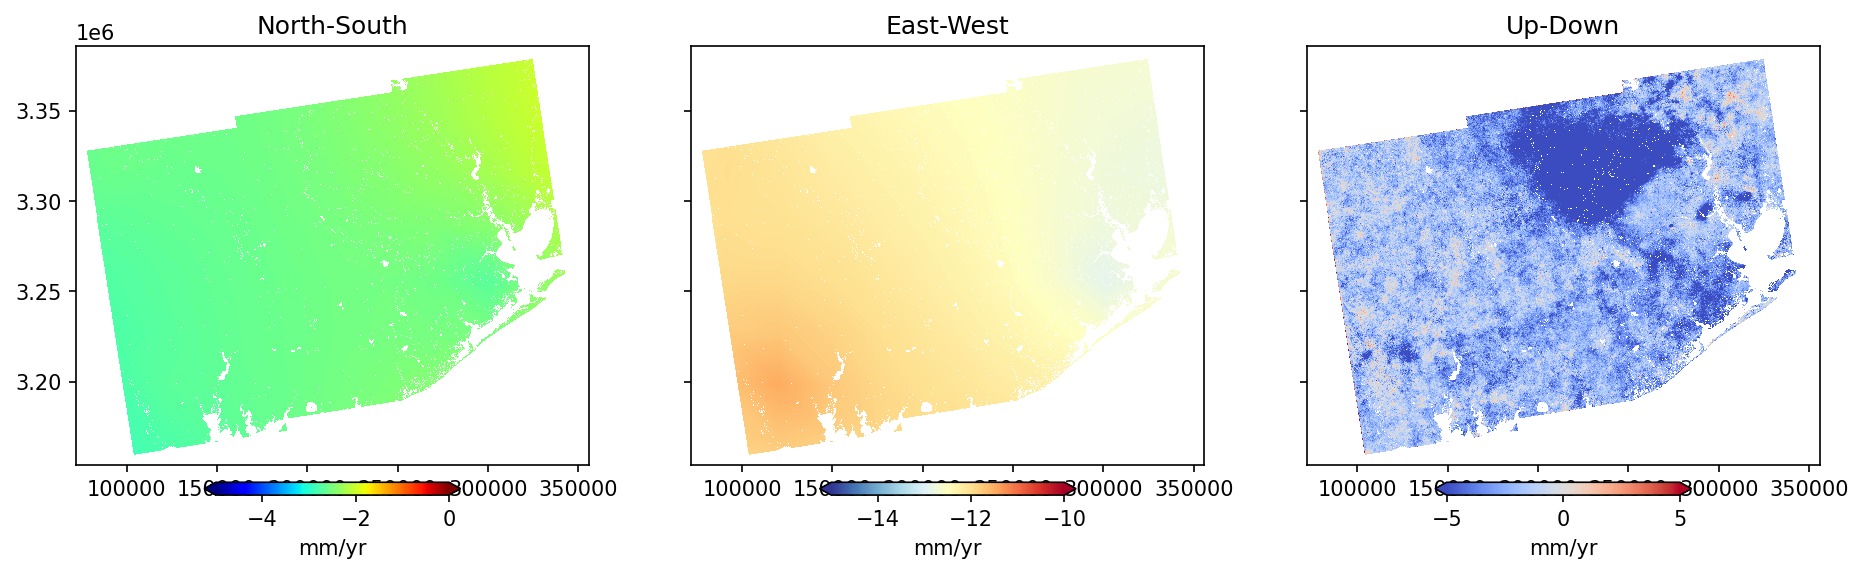

In [39]:
fig, ax = plt.subplots(1,3, figsize=[15,5], sharey=True, dpi=150)
im1=ax[0].imshow(np.ma.masked_array(comb_disp[0],
                                    mask=np.ma.masked_less(comb_ngeom,1).mask), 
                 clim=[-5, 0], 
                 cmap='jet', 
                 interpolation='nearest', extent=extent)
im2 = ax[1].imshow(np.ma.masked_array(comb_disp[1],
                                      mask=np.ma.masked_less(comb_ngeom,1).mask),
                   cmap='RdYlBu_r', clim=[-15, -10], interpolation='nearest', extent=extent)
im3 = ax[2].imshow(np.ma.masked_array(comb_disp[2],
                                      mask=np.ma.masked_less(comb_ngeom,1).mask), 
                    clim=[-5, 5], 
                    cmap='coolwarm', 
                    interpolation='nearest', extent=extent)
txt = ['North-South', 'East-West', 'Up-Down']
im = [im1, im2, im3]

for a, i, t in zip(ax, im, txt):
    fig.colorbar(i ,ax=a, location='bottom', shrink=0.5, label='mm/yr', extend='both',pad=0.03)
    a.set_title(t)

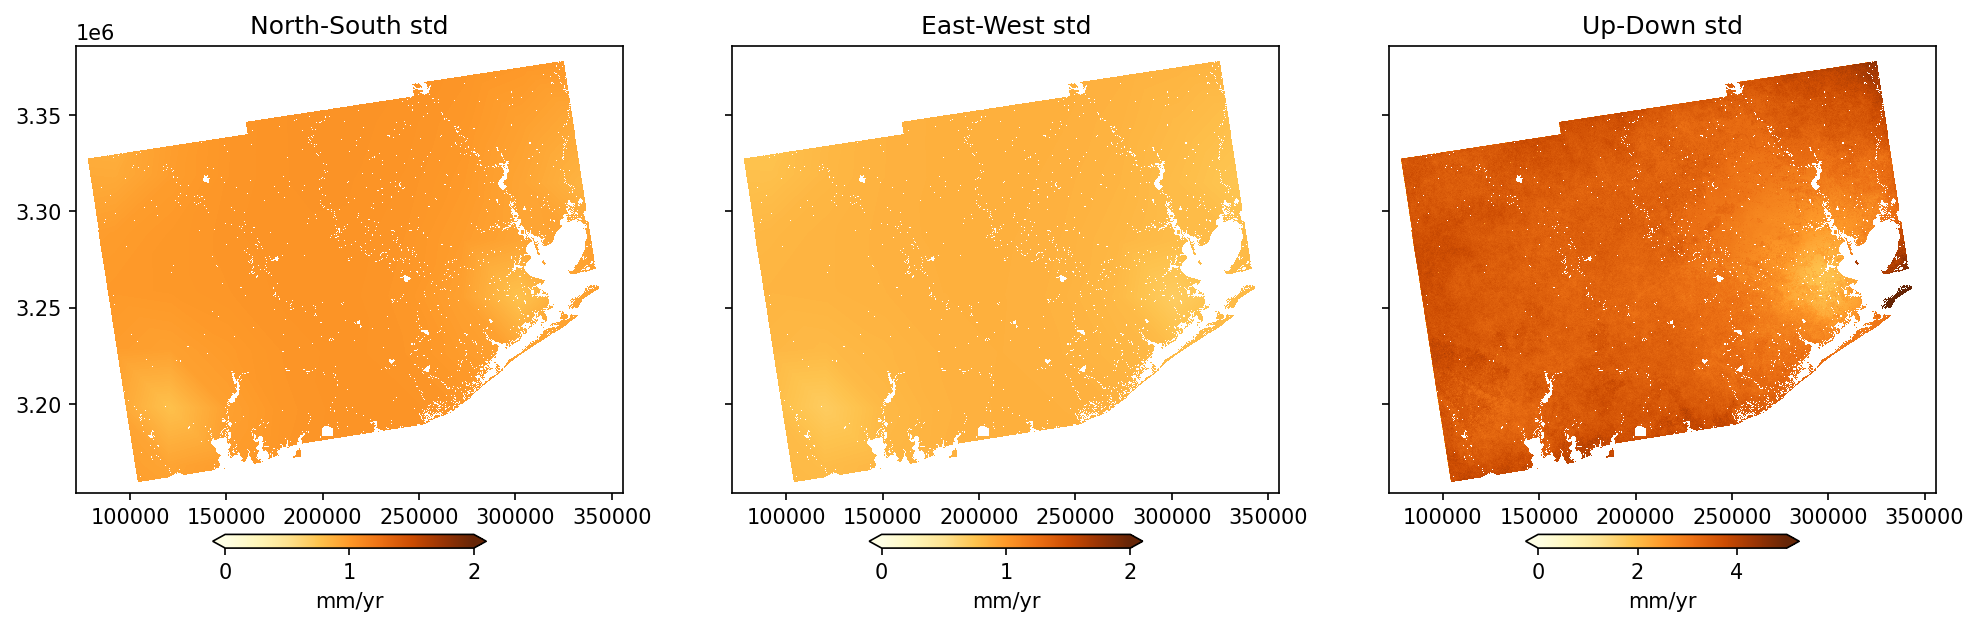

In [40]:
fig, ax = plt.subplots(1,3, figsize=[16,12], sharey=True, dpi=150)
im1=ax[0].imshow(np.ma.masked_array(comb_stdx[0],
                                    mask=np.ma.masked_less(comb_ngeom,1).mask), 
                 clim=[0,2], 
                 cmap='YlOrBr', 
                 interpolation='nearest', extent=extent)
im2 = ax[1].imshow(np.ma.masked_array(comb_stdx[1],
                                      mask=np.ma.masked_less(comb_ngeom,1).mask),
                   cmap='YlOrBr', clim=[0,2], interpolation='nearest', extent=extent)
im3 = ax[2].imshow(np.ma.masked_array(comb_stdx[2],
                                      mask=np.ma.masked_less(comb_ngeom,1).mask), 
                    clim=[0,5], 
                    cmap='YlOrBr', 
                    interpolation='nearest', extent=extent)
txt = ['North-South std', 'East-West std', 'Up-Down std']
im = [im1, im2, im3]

for a, i, t in zip(ax, im, txt):
    fig.colorbar(i ,ax=a, location='bottom', shrink=0.5, label='mm/yr', extend='both',pad=0.03)
    a.set_title(t)

In [41]:
np.nanmean(comb_stdx[2])

3.321761542525353

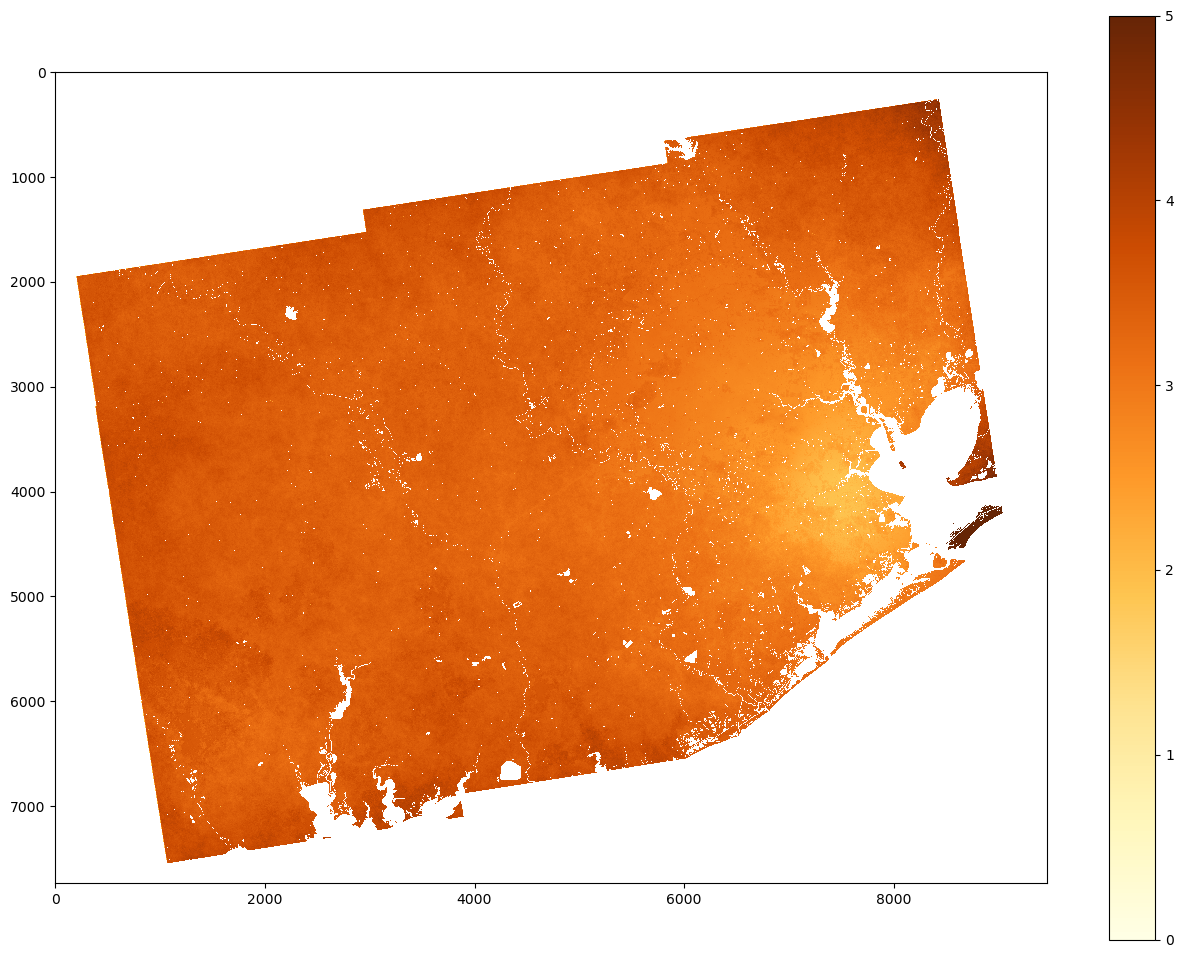

In [42]:
fig, ax = plt.subplots(1,1, figsize=[16,12])
im=ax.imshow(np.ma.masked_array(comb_stdx[2],
            mask=np.ma.masked_less(comb_ngeom,1).mask), 
          clim=[0,5], 
          cmap='YlOrBr', 
          interpolation='nearest')
fig.colorbar(im, ax=ax)

In [43]:
comb_dict['UNIT'] = 'mm/yr'
comb_dict['FILE_TYPE'] = 'velocity'
comb_dict['SNWE'] = snwe
ds_dict = dict(north_south=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None], 
               east_west=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               vlm=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               ns_std=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               ew_std=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               vlm_std=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               n_geom=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               mse=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               gnss_e=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               gnss_se=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               gnss_n=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None],
               gnss_sn=[np.float32, (comb_dict['LENGTH'], comb_dict['WIDTH']), None])

ds_unit_dict = dict(north_south='mm/yr', east_west='mm/yr', vlm='mm/yr',
                    ns_std='mm/yr', ew_std='mm/yr', vlm_std='mm/yr',
                    n_geom='#', mse='mm/yr', gnss_e='mm/yr', gnss_se='mm/yr',
                    gnss_n='mm/yr', gnss_sn='mm/yr')

In [44]:
from mintpy.utils import writefile
output = '/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/MIDAS_2000_2024/Houston_3d_disp-grid_25km.h5'
length, width = comb_dict['LENGTH'], comb_dict['WIDTH']
writefile.layout_hdf5(output,
                      metadata=comb_dict,
                      ds_name_dict=ds_dict,
                      ds_unit_dict=ds_unit_dict)

--------------------------------------------------
create HDF5 file: /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/MIDAS_2000_2024/Houston_3d_disp-grid_25km.h5 with w mode
create dataset  : north_south of <class 'numpy.float32'>   in size of (7733, 9464)         with compression = None
create dataset  : east_west   of <class 'numpy.float32'>   in size of (7733, 9464)         with compression = None
create dataset  : vlm         of <class 'numpy.float32'>   in size of (7733, 9464)         with compression = None
create dataset  : ns_std      of <class 'numpy.float32'>   in size of (7733, 9464)         with compression = None
create dataset  : ew_std      of <class 'numpy.float32'>   in size of (7733, 9464)         with compression = None
create dataset  : vlm_std     of <class 'numpy.float32'>   in size of (7733, 9464)         with compression = None
create dataset  : n_geom      of <class 'numpy.float32'>   in size of (7733, 9464)         with compression = None
create dataset  

'/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/MIDAS_2000_2024/Houston_3d_disp-grid_25km.h5'

In [45]:
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(comb_disp[0]).filled(fill_value=0),
                            datasetName='north_south')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(comb_disp[1]).filled(fill_value=0),
                            datasetName='east_west')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(comb_disp[2]).filled(fill_value=0),
                            datasetName='vlm')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(comb_stdx[0]).filled(fill_value=0),
                            datasetName='ns_std')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(comb_stdx[1]).filled(fill_value=0),
                            datasetName='ew_std')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(comb_stdx[2]).filled(fill_value=0),
                            datasetName='vlm_std')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(comb_ngeom).filled(fill_value=0),
                            datasetName='n_geom')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(gps_interpolated['ew']).filled(fill_value=0),
                            datasetName='gnss_e')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(gps_interpolated['se']).filled(fill_value=0),
                            datasetName='gnss_se')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(gps_interpolated['ns']).filled(fill_value=0),
                            datasetName='gnss_n')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_invalid(gps_interpolated['sn']).filled(fill_value=0),
                            datasetName='gnss_sn')

--------------------------------------------------
open  HDF5 file /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/MIDAS_2000_2024/Houston_3d_disp-grid_25km.h5 in a mode
writing dataset /north_south               block: [0, 7733, 0, 9464]
close HDF5 file /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/MIDAS_2000_2024/Houston_3d_disp-grid_25km.h5.
--------------------------------------------------
open  HDF5 file /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/MIDAS_2000_2024/Houston_3d_disp-grid_25km.h5 in a mode
writing dataset /east_west                 block: [0, 7733, 0, 9464]
close HDF5 file /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/MIDAS_2000_2024/Houston_3d_disp-grid_25km.h5.
--------------------------------------------------
open  HDF5 file /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/MIDAS_2000_2024/Houston_3d_disp-grid_25km.h5 in a mode
writing dataset /vlm                       block: [0, 7733, 0, 9464]
close HDF5 file /u/trappist-r0/govorci

'/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/VLM/MIDAS_2000_2024/Houston_3d_disp-grid_25km.h5'

In [92]:
yy, xx = np.ogrid[snwe[1]:snwe[0] + latlon_step[0]:(length)*1j,
                          snwe[2]:snwe[3] + latlon_step[1]:(width)*1j]

In [84]:
yy.shape, np.squeeze(comb_disp[2]).shape

((7733, 1), (7733, 9464))

In [93]:
attr = readfile.read_attribute(cal_insar_fft[0], datasetName='cal_velocity')

In [94]:
import xarray as xr
import rioxarray


ds = xr.DataArray(
    #np.ma.masked_array(comb_disp[2], mask=avg_tcoh<0.5).filled(fill_value=np.nan),
    #np.ma.masked_equal(comb_disp[2], 0).filled(fill_value=np.nan),
    np.ma.masked_array(comb_disp[2], mask=conncomp>40).filled(fill_value=np.nan),
    dims=['y','x'],
    coords={'x':  np.squeeze(xx), 'y':np.squeeze(yy)},
    attrs={'crs': f"EPSG:{attr['EPSG']}"}
)
ds = ds.rio.write_crs(f"EPSG:{attr['EPSG']}")

In [95]:
ds.rio.to_raster("output.tif")

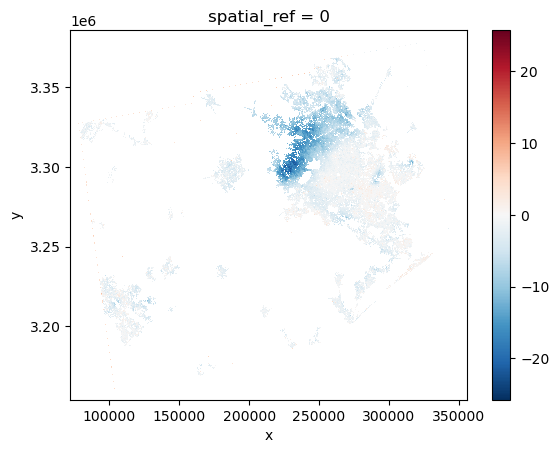

In [96]:
ds.plot.imshow()

In [97]:

ds_latlon = ds.rio.reproject("EPSG:4326")

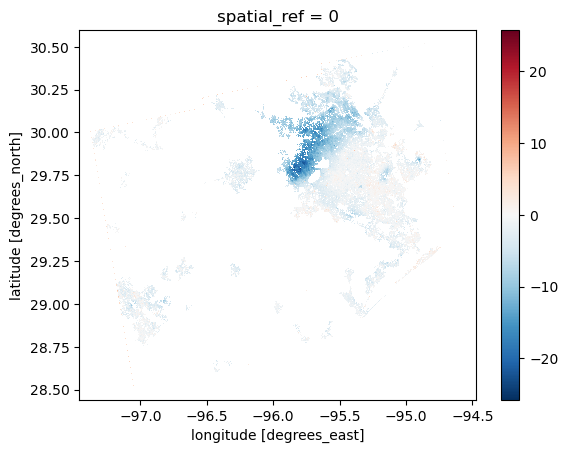

In [98]:
ds_latlon.plot.imshow()

In [99]:
import rasterio

In [100]:
with rasterio.open('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/opera_disp/MINTPY/aux/avg_tcoh.tif') as dataset:
    avg_tcoh = dataset.read(1)

In [101]:
with rasterio.open('/u/trappist-r0/govorcin/01_OPERA/VLM/Houston/opera_disp/MINTPY/aux/conncomp0_precent.tif') as dataset:
    conncomp = dataset.read(1)

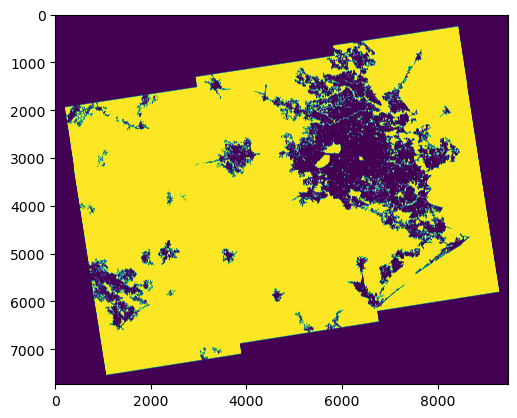

In [102]:
plt.imshow(conncomp>40)

In [103]:
from pykml import parser
from pykml.factory import KML_ElementMaker as KML
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import rasterio
from rasterio.enums import Resampling
from lxml import etree  # Import etree from lxml

# Step 2: Apply a colormap
norm = Normalize(vmin=-5, vmax=5)  # Normalize data to [0, 1]
cmap = plt.get_cmap("RdBu_r")  # Choose a colormap
rgba_data = cmap(norm(ds_latlon))  # Apply the colormap (RGBA values)

# Step 3: Handle NaN transparency
rgba_data[np.isnan(ds_latlon)] = [0, 0, 0, 0]  # Set NaNs to be transparent
# Mask using avg tcoherence
rgba_data = np.transpose(rgba_data, (2, 0, 1))

# Save the RGBA image as a GeoTIFF (with NaNs as transparent)
output_geotiff_path = "output_with_nans_transparent2.tif"
xr.DataArray(
    (rgba_data * 255).astype(np.uint8),  # Convert to 8-bit unsigned integer
    dims=["band", "y", "x"],
    coords={"y": ds_latlon.coords["y"], "x": ds_latlon.coords["x"], "band": ["red", "green", "blue", "alpha"]}
).rio.write_crs("EPSG:4326").rio.to_raster(output_geotiff_path)

# Step 4: Add Pyramid Overviews to the GeoTIFF
with rasterio.open(output_geotiff_path, "r+") as dataset:
    # Define overview levels (e.g., factors of 2, 4, 8, 16, etc.)
    overview_levels = [2, 4, 8, 16]
    dataset.build_overviews(overview_levels, Resampling.nearest)
    dataset.update_tags(ns="rio_overview", resampling="nearest")

# Step 5: Create KML using pykml
doc = KML.kml(
    KML.Document(
        KML.Name("GeoTIFF Overlay with Transparency"),
        KML.GroundOverlay(
            KML.name("Overlay with NaN Transparency"),
            KML.Icon(KML.href(output_geotiff_path)),
            KML.LatLonBox(
                KML.north(ds_latlon.coords['y'].max().item()),
                KML.south(ds_latlon.coords['y'].min().item()),
                KML.east(ds_latlon.coords['x'].max().item()),
                KML.west(ds_latlon.coords['x'].min().item())
            )
        )
    )
)

# Save KML file
kml_path = "output_with_nans_transparent2.kml"
with open(kml_path, 'w') as kml_file:
    kml_file.write(etree.tostring(doc, pretty_print=True).decode())

# Step 6: Create KMZ file (zip the KML and GeoTIFF)
kmz_path = "output_with_nans_transparent2.kmz"
with zipfile.ZipFile(kmz_path, 'w', zipfile.ZIP_DEFLATED) as kmz:
    kmz.write(kml_path, os.path.basename(kml_path))
    kmz.write(output_geotiff_path, os.path.basename(output_geotiff_path))
    #kmz.write("colorbar.png", os.path.basename("colorbar.png"))

# Clean up intermediate files
os.remove(kml_path)
#os.remove("colorbar.png")

from matplotlib import cm
def create_colorbar():
    fig, ax = plt.subplots(figsize=(1, 6))  # Set the size of the colorbar image
    norm = Normalize(vmin=-5, vmax=5)  # Set normalization based on your data
    cmap = cm.get_cmap("RdBu_r")
    
    # Create colorbar
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax)
    cbar.set_label("Value")
    
    # Save the colorbar as an image (PNG)
    legend_path = "colorbar.png"
    plt.savefig(legend_path, bbox_inches="tight", pad_inches=0)
    plt.close()

    return legend_path

print(f"KMZ file created: {kmz_path}")

KMZ file created: output_with_nans_transparent2.kmz
